<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/tonic-validate/Tonic_Validate_LlamaIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install --upgrade tonic_validate

In [7]:
%pip install --upgrade llama-index-postprocessor-cohere-rerank

In [8]:
!pip install --upgrade llama-index

In [9]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [10]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Mounted at /content/drive


Initialize LlamaIndex

In [11]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.embeddings.openai import OpenAIEmbedding, OpenAIEmbeddingModelType
from llama_index.llms.openai import OpenAI
from llama_index.postprocessor.cohere_rerank import CohereRerank

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['COHERE_API_KEY'] = userdata.get('COHERE_API_KEY')

Settings.llm = OpenAI(temperature=0.1, model="gpt-4-turbo")
Settings.embed_model = OpenAIEmbedding(model=OpenAIEmbeddingModelType.TEXT_EMBED_ADA_002)

Load benchmark questions & answers

In [12]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define LlamaIndex helper functions

In [13]:
def upload_essays():
    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    start_time = time.time()

    documents = SimpleDirectoryReader(directory).load_data()

    index = VectorStoreIndex.from_documents(documents, show_progress=True)

    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=10,
    )

    postprocessor = CohereRerank(
        top_n=2, model="rerank-english-v3.0", api_key=os.environ['COHERE_API_KEY']
    )

    query_engine = RetrieverQueryEngine(
       retriever=retriever,
       node_postprocessors=[postprocessor]
    )

    duration = time.time() - start_time

    current_time = datetime.now()
    formatted_time = current_time.strftime("%H:%M:%S")

    print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

    return query_engine

Define LlamaIndex RAG function

In [14]:
def get_llamaindex_rag_response(benchmarkItem: BenchmarkItem, query_engine):
    prompt = benchmarkItem.question

    response = query_engine.query(prompt)

    return response.response

Initialize LlamaIndex test

In [15]:
query_engine = upload_essays()

Parsing nodes:   0%|          | 0/212 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/866 [00:00<?, ?it/s]

Uploading essays took 33.26 seconds. Finished at 05:52:08 UTC.


Validate LlamaIndex response

In [16]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_llamaindex_rag_response(benchmark_item, query_engine))

According to Paul Graham, the key components necessary to create a technology hub are the presence of both rich people and nerds. Rich people are essential as they often have the experience and resources to invest in startups, providing not only capital but also advice and connections. Nerds, or highly skilled technical people, are crucial as they are the primary innovators and workforce behind startups. Additionally, an environment where startups are seen as a desirable or cool thing to do, and where there are frequent chance meetings with people who can provide support and opportunities, also plays a critical role in the success of a technology hub.


Perform LlamaIndex test and score run

In [17]:
raw_llamaindex_responses = []
for x in tqdm(benchmark.items):
    raw_llamaindex_responses.append(get_llamaindex_rag_response(x, query_engine))

100%|██████████| 55/55 [04:48<00:00,  5.25s/it]


In [18]:
llamaindex_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_llamaindex_responses, benchmark.items)
]

In [19]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
llamaindex_run = scorer.score_run(llamaindex_responses, parallelism=5)

Scoring responses:   4%|▎         | 2/55 [00:01<00:25,  2.09it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  11%|█         | 6/55 [00:01<00:11,  4.25it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  22%|██▏       | 12/55 [00:02<00:06,  6.66it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

In [20]:
llamaindex_run_df = run_to_dataframe(llamaindex_run)
llamaindex_run_df.to_csv(f"{tonic_validate_directory}/llamaindex_run.csv", index=False)

Visualize LlamaIndex test

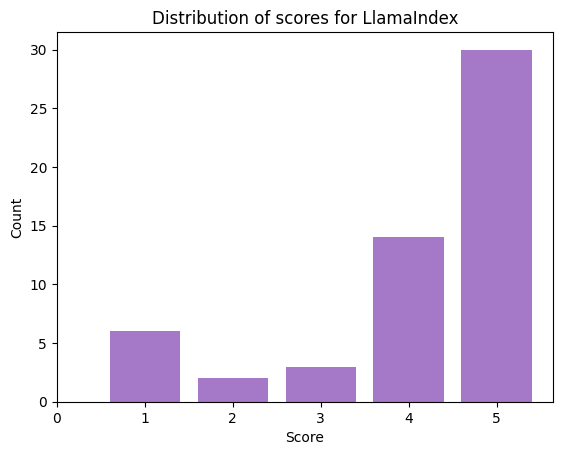

In [21]:
llamaindex_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in llamaindex_run.run_data])
category_counts = llamaindex_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for LlamaIndex')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()